In [1]:
# Import libraries and packages
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import sklearn

# Define path with .py codes containing functions used in this script
os.getcwd()
os.chdir( '../src/features')
# Import useful functions for this script  
from tracking import track


os.chdir( '../models')
from F_Models import save_plot,transform_dataset,WCSS_and_Elbow_Method,define_num_clusters,compute_PCA,compute_UMAP,plot_clusters

track("-"*25 + "CLUSTERING" + "-"*25)

# Reading data

#### Define path to data files

In [2]:
track("Defining path to data files")

# Define base path to data files
path = '../../temp_data/'

# Define path to the preprocesseded dataset that will be used in this script
path_preprocessed_data = path + 'model_data.csv'

# Ensure the input file exists
assert os.path.isfile(path_preprocessed_data), f'{path_preprocessed_data} not found. Is it a file?'

#### Read the files

In [3]:
# Read table with preprocesseded data that will be used in this script
track("Reading preprocessed data")
preprocessed_data = pd.read_csv(path_preprocessed_data)
track("Finished reading preprocessed data")

In [4]:
# Drop the column containing the name of the author
data = preprocessed_data.loc[:, preprocessed_data.columns != 'author']
track("Author column was dropped")

In [5]:
cluster_cols = ['author_timezone', 'commit_message', 'n_commits', 'n_projects_c', 'complexity', 'cognitive_complexity', 'duplicated_blocks', 'duplicated_files', 
                'duplicated_lines_density', 'open_issues', 'files', 'comment_lines_density', 'n_measures', 'n_projects_m', 'effort', 'message']

#quality_cols = ['violations', 'blocker_violations', 'critical_violations', 'major_violations', 'minor_violations', 'n_projects_i']
# info_violations, 'sqale_debt_ratio', 'code_smells', 'bugs', 'reliability_rating', 'vulnerabilities', 'security_rating', 
#'blocker','critical', 'info', 'major', 'minor', 'issue_code_length', 'n_issues'

# Model

#### K-means with normalized data

In [6]:
track("Starting mix max scaling of data")
# Min max scaling of data
track("Finished mix max scaling of data")
min_max_data = transform_dataset(data[cluster_cols],type="min_max")

In [7]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_none , number_of_clusters_none , silhouette_none = define_num_clusters(min_max_data,min_k=4, max_k=12, method="Normalized_data")
track("Finished WCSS and Elbow method for choosing the number of clusters")

#### K-means with PCA data

In [8]:
# Compute PCA
track("Starting to compute PCA")
PCA_data = compute_PCA(min_max_data, min_var=0.95)
track("Finished computing PCA")

In [9]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_PCA, number_of_clusters_PCA, silhouette_PCA = define_num_clusters(PCA_data,min_k=4,max_k=12,method ="PCA")
track("Finished WCSS and Elbow method for choosing the number of clusters")

#### K-means with UMAP data

In [10]:
track("Starting standardization of data")
# Standardization of data
track("Finished standardization of data")
standardized_data = transform_dataset(data[cluster_cols],type="standard")

In [11]:
# Compute UMAP
track("Starting to compute UMAP")
UMAP_data = compute_UMAP(standardized_data,n_neighbors=40,min_dist=0.01,n_components=10)
track("Finished computing UMAP")

In [12]:
# Compute the number of clusters and which cluster is every author
track("Starting WCSS and Elbow method for choosing the number of clusters")
clusters_UMAP, number_of_clusters_UMAP, silhouette_UMAP = define_num_clusters(UMAP_data,min_k=4,max_k=12,method ='UMAP')
track("Finished WCSS and Elbow method for choosing the number of clusters")

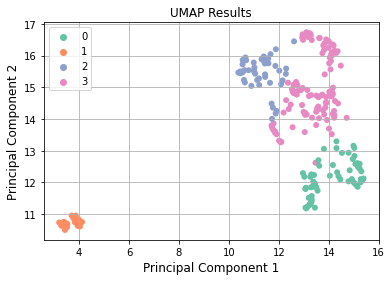

In [13]:
if silhouette_PCA > silhouette_UMAP and silhouette_PCA > silhouette_none:
    track("Computing PCA plot with K-Means clusters")
    plot_clusters(clusters_PCA, min_max_data,standardized_data,"PCA")
    preprocessed_data['clusters'] = clusters_PCA
elif silhouette_PCA < silhouette_UMAP and silhouette_UMAP > silhouette_none:
    track("Computing UMAP plot with K-Means clusters")
    plot_clusters(clusters_UMAP, min_max_data, standardized_data,"UMAP")
    preprocessed_data['clusters'] = clusters_UMAP
else:
    track("Computing PCA and UMAP plots with K-Means clusters")
    plot_clusters(clusters_none, min_max_data, standardized_data,"None")
    preprocessed_data['clusters'] = clusters_none

# Saving data with clusters

In [14]:
# Lastly, the final dataframe with the cluster variable is written in the suitable folder.

try: os.mkdir("../../temp_data/")
except: pass
preprocessed_data.to_csv("../../temp_data/model_data_with_clusters.csv", index_label = "author")